Load packages

In [1]:
import numpy as np
import radvel
import pickle
import pandas as pd
import sys
import re
import dynesty
DATADIR = "../data/"
sys.path+= ["../"]
import matplotlib.pyplot as plt
%matplotlib inline

unclosed file <_io.TextIOWrapper name='/Users/shadden/anaconda/lib/python3.6/site-packages/astropy/extern/bundled/six.py' mode='r' encoding='utf-8'>


In [2]:
from ResonantRV_Utils import get_acr_like
from ResonantPairModel import ACRModelPrior

# Example RV Fitting

This notebook constains examples demonstrating our ACR model and RV fitting methods. We conduct MCMC and nested sampling fits to compute posterior samples and estimate the Baysian evidence of the model. We generate `radvel.likelihood.CompositeLikelihood` and `radvel.posterior.Posterior` objects for the model under consideration.  The posterior objects are used in a MCMC fit to generate posterior samples.  The likelihood objects are used along side a transformation of the unit cube to run a nested sampling algorithm using `dynesty`.


We begin by selecting our example system as  **HD 33844**

In [3]:
ObservationsDF = pd.read_pickle(DATADIR+"All_Observations.pkl")
system='HD 33844'
Observations = ObservationsDF.query('system==@system')

# ACR model

Generate likelihood object for ACR model

In [4]:
res_j,res_k = 5,2
acr_model_like = get_acr_like(Observations,res_j,res_k,ACR_data_file="../ACR_locations_data.pkl")

Set initial parameter values to saved median values. This will provide a good initial guess for a max-likelihood fitting later.

In [5]:
with open(DATADIR + "/HD33844/acr_5to3_ACR_fit_parameter_medians.pkl","rb") as fi:
    median_vals = pickle.load(fi)
vary_pars = [median_vals[key] for key in acr_model_like.list_vary_params()]
acr_model_like.set_vary_params(vary_pars)
acr_model_like.params['angle_n'].value = int(median_vals['angle_n'])

Create posterior object for radvel MCMC fit

In [6]:
acr_model_post = radvel.posterior.Posterior(acr_model_like)
acrpriors = [
    ACRModelPrior(),
    radvel.prior.Jeffreys('k1',0.2 * median_vals['k1'], 5 * median_vals['k1'] ),
    radvel.prior.Jeffreys('m2_by_m1',0.1,10)
]
acr_model_post.priors += acrpriors

Get max-likelihood starting point using scipy's minimize

In [7]:
from scipy.optimize import minimize

In [8]:
print("Before fit: logprob: {:.2f}, loglike: {:.2f}".format(acr_model_post.logprob(),acr_model_post.logprob()))

minresult = minimize(acr_model_post.neglogprob_array,acr_model_post.get_vary_params())

print("After fit: logprob: {:.2f}, loglike: {:.2f}".format(acr_model_post.logprob(),acr_model_post.logprob()))

Before fit: logprob: -234.35, loglike: -234.35
After fit: logprob: -233.91, loglike: -233.91


Take a look at the fit

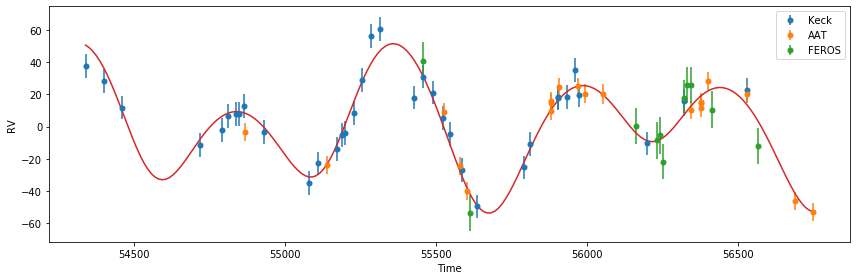

In [9]:
from ResonantRV_Utils import plot_fit
plot_fit(acr_model_post.likelihood)
plt.legend()

### 2.1 MCMC Fit

In [11]:
acr_model_mcmc_results = radvel.mcmc(acr_model_post,nrun=500)
# Setting nrun small for the sake of example. 

20000/200000 (10.0%) steps complete; Running 6136.32 steps/s; Mean acceptance rate = 43.3%; Min Auto Factor =  18; Max Auto Relative-Change =   inf; Min Tz = 3877.3; Max G-R = 1.007
Discarding burn-in now that the chains are marginally well-mixed

200000/200000 (100.0%) steps complete; Running 5989.16 steps/s; Mean acceptance rate = 36.9%; Min Auto Factor =  32; Max Auto Relative-Change = 0.141; Min Tz = 5939.0; Max G-R = 1.005

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


Convert parameters of ACR model to conventional orbital elements and planet parameters.
New parameters are added as columns to the dataframe `acr_model_mcmc_results`:

In [12]:
from ResonantRV_Utils import process_acr_posterior_dataframe

process_acr_posterior_dataframe(
    acr_model_mcmc_results,
    acr_model_like,
    Mstar=median_vals['Mstar']
)

In [13]:
acr_model_mcmc_results.columns

Index(['per1', 'tc1', 'k1', 'm2_by_m1', 'stcosw', 'stsinw', 'gammaAAT',
       'jitAAT', 'gammaFEROS', 'jitFEROS', 'gammaKeck', 'jitKeck',
       'lnprobability', 'timebase', 't', 'Mstar', 'pomega1', 'e1', 'tp1', 'M1',
       'l1', 'm1', 'jres', 'kres', 'angle_n', 'm2', 'e2', 'pomega2', 'per2',
       'M2', 'tp2', 'secosw1', 'sesinw1', 'secosw2', 'sesinw2'],
      dtype='object')

The cells below show the eccentricity posteriors of the ACR model. 
ACR tracks for the 1st and 99th percentile $m_2/m_1$ values are plotted for comparison.

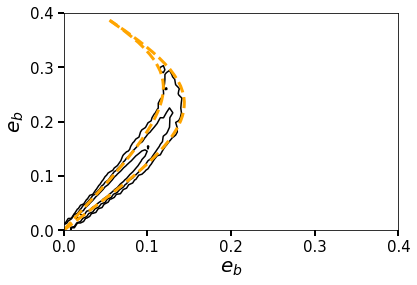

In [14]:
from corner import hist2d
from scipy.special import erf
fig,ax = plt.subplots(1)
plt.tick_params(labelsize=15,size=6,width=2)

# 2D histogram of eccentricities
hist2d(
    acr_model_mcmc_results['e1'].values,acr_model_mcmc_results['e2'].values,
    bins = 40,
    levels=[erf(i/np.sqrt(2)) for i in range(1,4)],
    plot_datapoints=False, plot_density=False,
    ax = ax    
)

for mratio in acr_model_mcmc_results.m2_by_m1.quantile((.01,0.99)):
    # Compute acr track for given m2/m1 vale
    x,y = np.transpose([ acr_model_post.likelihood.model._acr_curves_fn(mratio,t) for t in np.linspace(0,1)])
    ax.plot(x,y,lw=3,color='orange',ls='--')
ax.set_xlim(0,0.4)
ax.set_ylim(0,0.4)
ax.set_xlabel("$e_b$",fontsize=20);
ax.set_ylabel("$e_b$",fontsize=20);

### 2.2 Nested sampling fit

Generate a (callable) prior transform object that defines a mapping from the unit hyper-cube to the parameters appearing in the likelihood model. The unit-hypercube is sampled uniformly by the nested sampling algorithm.

In [15]:
from ResonantPairModel import ACRModelPriorTransform
acr_model_prior_transform = ACRModelPriorTransform(Observations,acr_model_like)

Get a dynesty NestedSample object

In [16]:
sampler_acr_model = dynesty.NestedSampler(
    acr_model_like.logprob_array,
    acr_model_prior_transform,
    acr_model_prior_transform.Npars,
    sample='rwalk'
)

Run nested sampling

In [ ]:
_ = sampler_acr_model.run_nested()

Save the results of nested sampling run.

In [ ]:
acr_model_nested_results = sampler_acr_model.results

In [ ]:
acr_model_nested_results['logz'][-1]